# 第6章: 機械学習

本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

In [3]:
import pandas as pd
import numpy as np
import csv
import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm

## 50. データの入手・整形

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [4]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
# !unzip NewsAggregatorDataset.zip

In [5]:
with open("newsCorpora.csv",'r') as news:
  data = news.read()
data_table = []
for row in data.split('\n'):
  data_table.append(row.split('\t'))
df = pd.DataFrame(data_table)
df.set_axis(['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'], axis=1, inplace=True)
df = df.set_index('ID')

extractPublisher = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df.loc[df['PUBLISHER'].isin(extractPublisher)]

df = df.sample(frac=1, random_state=42)
train, valid, test = np.split(df, [int(.8*len(df)), int(.9*len(df))])

In [6]:
train.to_csv('train.txt',sep='\t',quoting=csv.QUOTE_NONE)
valid.to_csv('valid.txt',sep='\t',quoting=csv.QUOTE_NONE)
test.to_csv('test.txt',sep='\t',quoting=csv.QUOTE_NONE)

## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [1]:
def preprocess(text):
  text = text.lower()
  text = re.sub(r"[.?!-/:;\"]",'',text)
  text = re.sub(r"[0-9]","",text)
  return text

In [8]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer
# title_wordlist = [x.split() for x in title_processed]

TfidfVectorizer(min_df=5)

In [9]:
def featureExtractFT(df):
  title = df.TITLE
  title_processed = [preprocess(x) for x in title]
  X = vectorizer.fit_transform(title_processed)
  return X.toarray()

def featureExtractT(df):
  title = df.TITLE
  title_processed = [preprocess(x) for x in title]
  X = vectorizer.transform(title_processed)
  return X.toarray()

In [10]:
# def featureExtract(df):
#   title = df.TITLE
#   title_processed = [preprocess(x) for x in title]
#   title_wordlist = [x.split() for x in title_processed]
#   X = vectorizer.fit_transform(title_processed)
#   new_df = df.drop(['URL','STORY','HOSTNAME','TIMESTAMP'],axis=1,inplace=False)
#   new_df['TOKEN'] = title_wordlist
#   return new_df
  # print(len(df))
  # df['VEC'] = X.toarray()

In [11]:
train_extracted = pd.DataFrame(featureExtractFT(train), columns=vectorizer.get_feature_names())
valid_extracted = pd.DataFrame(featureExtractT(valid), columns=vectorizer.get_feature_names())
test_extracted = pd.DataFrame(featureExtractT(test), columns=vectorizer.get_feature_names())

In [12]:
train_extracted.to_csv('train.feature.txt',sep='\t',quoting=csv.QUOTE_NONE)
valid_extracted.to_csv('valid.feature.txt',sep='\t',quoting=csv.QUOTE_NONE)
test_extracted.to_csv('test.feature.txt',sep='\t',quoting=csv.QUOTE_NONE)

## 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [13]:
train_extracted.shape

(10684, 3631)

In [14]:
test_extracted.shape

(1336, 3631)

In [15]:
logreg = LogisticRegression()
X = train_extracted
Y = train.CATEGORY
logreg.fit(X,Y)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [16]:
Ypred = logreg.predict(test_extracted)
Ypred

array(['b', 't', 'e', ..., 'e', 'b', 'e'], dtype=object)

## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [17]:
# 学習データ
YTrainPred = logreg.predict(train_extracted)
accuracy_score(train['CATEGORY'],YTrainPred)

0.9348558592287532

In [18]:
# 評価データ
accuracy_score(test['CATEGORY'],Ypred)

0.9079341317365269

## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [19]:
# 学習データ
confusion_matrix(train['CATEGORY'],YTrainPred)

array([[4366,   71,    8,   55],
       [  38, 4171,    1,    6],
       [  83,  127,  525,    7],
       [ 173,  119,    8,  926]])

In [20]:
# 評価データ
confusion_matrix(test['CATEGORY'],Ypred)

array([[559,  15,   2,   6],
       [  6, 528,   0,   2],
       [ 16,  17,  40,   4],
       [ 33,  21,   1,  86]])

## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．



In [21]:
precision_recall_fscore_support(test['CATEGORY'], Ypred, average='micro')

(0.9079341317365269, 0.9079341317365269, 0.9079341317365269, None)

In [22]:
precision_recall_fscore_support(test['CATEGORY'], Ypred, average='macro')

(0.9067462500838401, 0.7687413310041833, 0.8166259958295257, None)

## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [23]:
categories = ['b','e','m','t']

In [24]:
for i,cate in enumerate(categories):
  print(cate)
  np.argsort(logreg.coef_[i])
  top10 = np.argsort(logreg.coef_[i])[:-11:-1]
  bottom10 = np.argsort(logreg.coef_[i])[:10]
  print("top10:", end=" ")
  for f in top10:
    print(vectorizer.get_feature_names()[f], end=" ")
  print()
  print("bottom10:", end=" ")
  for f in bottom10:
    print(vectorizer.get_feature_names()[f], end=" ")
  print('')

b
top10: bank fed ecb china ukraine euro profit stocks oil update 
bottom10: and her ebola video star fda she study drug kardashian 
e
top10: kardashian chris kim paul miley cyrus her wedding movie star 
bottom10: us update google study ceo facebook gm billion china says 
m
top10: ebola cancer fda study drug mers health cases heart medical 
bottom10: gm facebook climate google apple ceo bank deal twitter sales 
t
top10: google facebook apple climate microsoft gm comcast fcc heartbleed space 
bottom10: stocks her high fed health percent cancer drug ukraine american 


## 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [25]:
accuracy_train = []
accuracy_valid = []
accuracy_test = []

X = train_extracted
Y = train.CATEGORY
for c in range(-5,5):
  logreg = LogisticRegression(C=10**c)
  logreg.fit(X,Y)
  YTrainPred = logreg.predict(train_extracted)
  YValidPred = logreg.predict(valid_extracted)
  YTestPred = logreg.predict(test_extracted)
  accuracy_train.append(accuracy_score(train['CATEGORY'],YTrainPred))
  accuracy_valid.append(accuracy_score(valid['CATEGORY'],YValidPred))
  accuracy_test.append(accuracy_score(test['CATEGORY'],YTestPred))

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [26]:
print("Train: ")
print(["{:.4f}".format(x) for x in accuracy_train])
print()
print("Valid: ")
print(["{:.4f}".format(x) for x in accuracy_valid])
print()
print("Test: ")
print(["{:.4f}".format(x) for x in accuracy_test])

Train: 
['0.4212', '0.4212', '0.4505', '0.7522', '0.7941', '0.9349', '0.9884', '0.9987', '0.9993', '0.9993']

Valid: 
['0.4079', '0.4079', '0.4364', '0.7395', '0.7777', '0.8900', '0.9064', '0.9094', '0.8922', '0.8937']

Test: 
['0.4356', '0.4356', '0.4633', '0.7814', '0.8016', '0.9079', '0.9169', '0.9072', '0.9004', '0.8960']


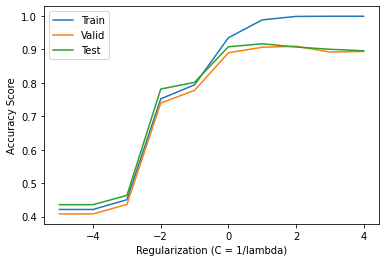

In [27]:
# regularize = [1/(10**c) for c in range(-5,5)]
c = range(-5, 5)
plt.plot(c, accuracy_train, label = "Train")
plt.plot(c, accuracy_valid, label = "Valid")
plt.plot(c, accuracy_test, label = "Test")
plt.legend()
plt.xlabel("Regularization (C = 1/lambda)")
plt.ylabel("Accuracy Score")
plt.show()

## 59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [32]:
param_grid = {
#   'svm':{
#     'model':svm.SVC(gamma='auto'),
#     'params':{
#       'C':[10**c for c in range(-5,5)],
#       'kernel':['rbf','linear']
#     }
#   },
  'random_forest':{
    'model': RandomForestClassifier(),
    'params':{
      'n_estimators':list(range(10,101,10))
    }
  },
  'logistic regression':{
    'model':LogisticRegression(solver='liblinear',multi_class='auto'),
    'params':{
      'C':[10**c for c in range(-5,5)]
    }
  }
}

scores = []

for model, param in param_grid.items():
  clf = GridSearchCV(param['model'], 
                           param['params'], 
                           cv=5, 
                           return_train_score=False)
  clf.fit(train_extracted, train.CATEGORY)
  scores.append({
    'model': model,
    'best_score': clf.best_score_,
    'best_params': clf.best_params_
  })
  
pd.DataFrame(scores, columns=['model','best_score','best_params'])

,model,best_score,best_params
0,random_forest,0.805316,{'n_estimators': 100}
1,logistic regression,0.899007,{'C': 10}


In [38]:
model = LogisticRegression(solver='liblinear',multi_class='auto',C = 10)
model.fit(train_extracted,train['CATEGORY'])
YTestPred = model.predict(test_extracted)
accuracy_score(test['CATEGORY'], YTestPred)

0.9169161676646707